<a href="https://colab.research.google.com/github/capofwesh20/Modeling-Expected-Loss/blob/main/Modeling_Credit_Risk_Expected_Loss_%26_Time_to_Default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

About the Data

LendingClub is a US peer-to-peer lending company, headquartered in San Francisco, California. It was the first peer-to-peer lender to register its offerings as securities with the Securities and Exchange Commission (SEC), and to offer loan trading on a secondary market. LendingClub is the world's largest peer-to-peer lending platform. This dataset contains the full LendingClub data available from [their site](https://www.lendingclub.com/personal-savings/founder-savings). There are separate files for accepted and rejected loans. The accepted loans also include the FICO scores, which can only be downloaded when you are signed in to LendingClub and download the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
from imblearn.over_sampling import SMOTE

Notebook Goals

The goal of this notebook is the use the Five C's of credit framework (Character, Capacity, Cash Flow, Collateral, and Condition) to select the proxy features from the Lending Club Dataset to predict loan default probability.

Using the predicted loan default probability, the notebook will the generate expected loss on loans within the portfolio.

Expected Loss (EL) on a given is calculuated using the loan amount multiplied by a loan's probability of default (PD) mulitplied by the the loan's loss given default (LGD). Loss Given Default is the amount of the loan that is deemed unrecoverable and is represented as a number between 0 (no loss) and 1 (100% of the loan is a loss)

The equation for EL is given as:

* EL = PD x LGD x Loan Amount

After selected features using the 5 C's of Credit Framework and adjusting for the skewedness in the data (there is a greater proportion of loans in the portfolio that have NOT defaulted versus loans that HAVE defaulted) we will model proabilities of default using classification models.

With proabilties of default we will then model Expected Loss using an assumed LGD of 1 (a LGD of 1 is a conservative assumption given the unsecured nature of the loans)

In [2]:
raw_data = pd.read_csv("/content/drive/MyDrive/loan.csv/loan.csv",low_memory=False)
raw_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
preprocess_df = raw_data[['emp_length', 'loan_status', 'home_ownership', 'issue_d',
                          'earliest_cr_line', 'purpose', 'term', 'annual_inc', 'dti',
                          'loan_amnt', 'int_rate', 'pub_rec_bankruptcies',]].copy()

In [4]:
preprocess_df = raw_data[['emp_length', 'loan_status', 'home_ownership', 'issue_d',
                          'earliest_cr_line', 'purpose', 'term', 'annual_inc', 'dti',
                          'loan_amnt', 'int_rate', 'pub_rec_bankruptcies',]].copy()
# Create a list of columns that are NOT numeric values
not_numeric_cols = ['emp_length', 'loan_status', 'home_ownership', 'issue_d',
                    'earliest_cr_line', 'purpose', 'term']

# Create list of columns that ARE numeric values and print
numeric_cols = [col for col in preprocess_df.columns if col not in not_numeric_cols]
print(numeric_cols)

# Convert numeric cols into numeric data types
preprocess_df[numeric_cols] = preprocess_df[numeric_cols].apply(pd.to_numeric)

['annual_inc', 'dti', 'loan_amnt', 'int_rate', 'pub_rec_bankruptcies']


In [5]:
# Create list of datetime columns
datetime_cols = ['earliest_cr_line', 'issue_d']

# Convert to datetime
preprocess_df[datetime_cols] = preprocess_df[datetime_cols].apply(pd.to_datetime)

<ipython-input-5-1b9eedca8d12>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  preprocess_df[datetime_cols] = preprocess_df[datetime_cols].apply(pd.to_datetime)
<ipython-input-5-1b9eedca8d12>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  preprocess_df[datetime_cols] = preprocess_df[datetime_cols].apply(pd.to_datetime)


Missing Data / Missing Observations

In [6]:
preprocess_df.isnull().sum()

emp_length              146907
loan_status                  0
home_ownership               0
issue_d                      0
earliest_cr_line            29
purpose                      0
term                         0
annual_inc                   4
dti                       1711
loan_amnt                    0
int_rate                     0
pub_rec_bankruptcies      1365
dtype: int64

# **Character: pub_rec_bankruptcies, earliest_cr_line, issue_d**

What it is: A lender’s opinion of a borrower’s general trustworthiness, credibility and personality. Not only the willingness of the oblgior to repay an obligation, and live up to its terms, but also honesty relative to the risk of fraud.

Why it matters: Banks want to lend to people who are responsible and keep commitments.

How it’s assessed: From your work experience, credit history, credentials, references, reputation and interaction with lenders.

In [7]:
character_df = preprocess_df[['pub_rec_bankruptcies', 'earliest_cr_line', 'issue_d']].copy()

In [11]:
character_df.head()


,pub_rec_bankruptcies,earliest_cr_line,issue_d
0,1.0,2001-04-01,2018-12-01
1,1.0,1987-06-01,2018-12-01
2,0.0,2011-04-01,2018-12-01
3,0.0,2006-02-01,2018-12-01
4,0.0,2000-12-01,2018-12-01


In [12]:
character_df.describe()


,pub_rec_bankruptcies,earliest_cr_line,issue_d
count,2.259303e+06,2260639,2260668
mean,1.281935e-01,1999-12-10 16:39:39.736349824,2016-05-02 18:48:08.652734976
min,0.000000e+00,1933-03-01 00:00:00,2007-06-01 00:00:00
25%,0.000000e+00,1995-11-01 00:00:00,2015-04-01 00:00:00
50%,0.000000e+00,2001-04-01 00:00:00,2016-07-01 00:00:00
75%,0.000000e+00,2005-05-01 00:00:00,2017-11-01 00:00:00
max,1.200000e+01,2015-11-01 00:00:00,2018-12-01 00:00:00
std,3.646130e-01,NaN,NaN


In [13]:
character_df.dtypes

pub_rec_bankruptcies           float64
earliest_cr_line        datetime64[ns]
issue_d                 datetime64[ns]
dtype: object

'earliest_cr_line' shows the first credit line on the customer credit report.

Will create a new feature that shows the number of months between the first credit line in the customers history and the issue date of the loan.

In [8]:
# fill the missing value for earliest_cr_line with most frequently occuring
character_df['earliest_cr_line'].fillna(character_df['earliest_cr_line'].value_counts().index[0], inplace=True)

In [9]:
# count months between now and 'earliest_cr_line'
character_df['credit_hist_in_months'] = ((character_df['issue_d'] - character_df['earliest_cr_line'])/np.timedelta64(1, 'M'))
character_df['credit_hist_in_months'] = character_df['credit_hist_in_months'].astype(int)

character_df.head()

,pub_rec_bankruptcies,earliest_cr_line,issue_d,credit_hist_in_months
0,1.0,2001-04-01,2018-12-01,208
1,1.0,1987-06-01,2018-12-01,371
2,0.0,2011-04-01,2018-12-01,90
3,0.0,2006-02-01,2018-12-01,151
4,0.0,2000-12-01,2018-12-01,212


In [10]:
# Create a new binary feature of whether or not there is a bankruptcy on file in customers credit history
character_df['cb_person_bk_on_file_Y'] = character_df['pub_rec_bankruptcies'].apply(lambda x: 1 if x >= 1 else 0)
character_df.head()

,pub_rec_bankruptcies,earliest_cr_line,issue_d,credit_hist_in_months,cb_person_bk_on_file_Y
0,1.0,2001-04-01,2018-12-01,208,1
1,1.0,1987-06-01,2018-12-01,371,1
2,0.0,2011-04-01,2018-12-01,90,0
3,0.0,2006-02-01,2018-12-01,151,0
4,0.0,2000-12-01,2018-12-01,212,0


In [11]:
# drop the old features from the character_df
character_df.drop(['pub_rec_bankruptcies', 'earliest_cr_line', 'issue_d'], axis=1, inplace=True)
character_df.head()

,credit_hist_in_months,cb_person_bk_on_file_Y
0,208,1
1,371,1
2,90,0
3,151,0
4,212,0


# **Capacity/Cash flow: annual_inc & dti**
What it is: Your ability to repay the loan. The ability to generate cash to repay all oblgiations, when due. Assessing this is the primary goal of credit analysis

Why it matters: Lenders want to be assured that your business generates enough cash flow to repay the loan in full.

In [12]:
capacity_df = preprocess_df[['annual_inc', 'dti']].copy()
capacity_df.head()

,annual_inc,dti
0,55000.0,18.24
1,90000.0,26.52
2,59280.0,10.51
3,92000.0,16.74
4,57250.0,26.35


In [13]:
# fill missing values for annual income with the mean
capacity_df['annual_inc'] = capacity_df['annual_inc'].fillna(capacity_df['annual_inc'].mean())

# fill missing values for dti with the mean
capacity_df['dti'] = capacity_df['dti'].fillna(capacity_df['dti'].mean())

In [14]:
# describe the capacity/cash flow proxy features
capacity_df[['annual_inc', 'dti']].describe()

,annual_inc,dti
count,2.260668e+06,2.260668e+06
mean,7.799243e+04,1.882420e+01
std,1.126961e+05,1.417796e+01
min,0.000000e+00,-1.000000e+00
25%,4.600000e+04,1.190000e+01
50%,6.500000e+04,1.785000e+01
75%,9.300000e+04,2.448000e+01
max,1.100000e+08,9.990000e+02


# **Capital**
What it is: The amount of money invested by the business owner or management team. It is required during periods of weak cash flow generation for an obligor to sustain itself and meeet obligations. If there isn't sufficient cash flow to meet obligations, then assets may need to be sold to meet obligations.

Why it matters: Banks are more willing to lend to owners who have invested some of their own money into the venture. It shows you have some “skin in the game.”

How it’s assessed: From the amount of money the borrower or management team has invested in the business.

# **NO PROXY FEATURES USED FOR CAPITAL**


# **Conditions : loan_amnt, int_rate, term**

What it is: The condition of a business/individual — whether it is growing or faltering — as well as what you’ll use the funds for. Refers to the macro-economic and competitive environment which will impact an obligor's future performance and its ability to generate cash.

Why it matters: To ensure that loans are repaid, banks want to lend to businesses operating under favorable conditions. They aim to identify risks and protect themselves accordingly.

How it’s assessed: From a review of the competitive landscape, supplier and customer relationships, and macroeconomic and industry-specific issues.

In [15]:
conditions_df = preprocess_df[['loan_amnt', 'int_rate', 'term']].copy()

In [16]:
conditions_df.term.value_counts()

term
 36 months    1609754
 60 months     650914
Name: count, dtype: int64

In [17]:
# Convert values of term to 0, 1 where 0 = 36 months and 1 = 60 months
conditions_df['term'] = conditions_df['term'].replace({' 36 months': '0',
                                                       ' 60 months': '1'})

# convert term into an integer data type
conditions_df['term'] = conditions_df['term'].astype(int)

# Rename term column
conditions_df = conditions_df.rename(columns={'term': 'term_60'})

print(conditions_df.term_60.value_counts())
conditions_df.head()

term_60
0    1609754
1     650914
Name: count, dtype: int64


,loan_amnt,int_rate,term_60
0,2500,13.56,0
1,30000,18.94,1
2,5000,17.97,0
3,4000,18.94,0
4,30000,16.14,1


# **Collateral: home_ownership**
What it is: Assets that are used to guarantee or secure a loan.

Why it matters: Collateral is a backup source if the borrower cannot repay a loan.

In [18]:
collateral_df = preprocess_df[['home_ownership']].copy()
collateral_df.head(10)

,home_ownership
0,RENT
1,MORTGAGE
2,MORTGAGE
3,MORTGAGE
4,MORTGAGE
5,MORTGAGE
6,RENT
7,RENT
8,MORTGAGE
9,OWN


In [29]:
collateral_df.nunique()

home_ownership_ANY         2
home_ownership_MORTGAGE    2
home_ownership_NONE        2
home_ownership_OTHER       2
home_ownership_OWN         2
home_ownership_RENT        2
dtype: int64

In [19]:
# create emp_length dummy data frame
home_ownership = pd.DataFrame(pd.get_dummies(collateral_df['home_ownership'], prefix='home_ownership'))

home_ownership.head()

,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,False,False,False,False,False,True
1,False,True,False,False,False,False
2,False,True,False,False,False,False
3,False,True,False,False,False,False
4,False,True,False,False,False,False


In [21]:
# Convert all boolean columns to integers
home_ownership = home_ownership.astype(int)
home_ownership.head()

,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,0,0,0,0,0,1
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0


In [22]:
# join the loan_amnt dummy dataframe to conditions_df
collateral_df = pd.concat([collateral_df, home_ownership], axis=1, sort=False)

# drop original emp_length feature
collateral_df.drop(['home_ownership'], axis=1, inplace=True)

collateral_df.head()

,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,0,0,0,0,0,1
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0


# **Loan Status**
Current Status of the Loan. Target variable

In [23]:
loan_status_df = preprocess_df[['loan_status']].copy()
loan_status_df.loan_status.value_counts()

loan_status
Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: count, dtype: int64

In [24]:
loan_status_df['loan_status'] = loan_status_df['loan_status'].replace({'Fully Paid': 0, 'Current': 0, 'Charged Off': 1,
                                                                       'Late (31-120 days)': 1, 'In Grace Period': 1,
                                                                       'Late (16-30 days)':1,
                                                                       'Does not meet the credit policy. Status:Fully Paid': 0,
                                                                       'Does not meet the credit policy. Status:Charged Off': 1,
                                                                       'Default':1})
loan_status_df.loan_status.value_counts()

loan_status
0    1963635
1     297033
Name: count, dtype: int64

# **Combine all the processed dataframes together into a single one**

In [25]:
processed_df = pd.concat([character_df,
                          capacity_df,
                          conditions_df,
                          collateral_df,
                          loan_status_df,
                          raw_data['grade']], axis=1, sort=False)
processed_df.head()

,credit_hist_in_months,cb_person_bk_on_file_Y,annual_inc,dti,loan_amnt,int_rate,term_60,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,loan_status,grade
0,208,1,55000.0,18.24,2500,13.56,0,0,0,0,0,0,1,0,C
1,371,1,90000.0,26.52,30000,18.94,1,0,1,0,0,0,0,0,D
2,90,0,59280.0,10.51,5000,17.97,0,0,1,0,0,0,0,0,D
3,151,0,92000.0,16.74,4000,18.94,0,0,1,0,0,0,0,0,D
4,212,0,57250.0,26.35,30000,16.14,1,0,1,0,0,0,0,0,C


# **Count total Non-Defualt and Defaulted Loans in the Data Set**
Where '0' is a loan that has NOT defaulted and '1' is a loan that HAS defaulted

In [26]:
processed_df.loan_status.value_counts()

loan_status
0    1963635
1     297033
Name: count, dtype: int64

Text(0, 0.5, 'Number of Loans')

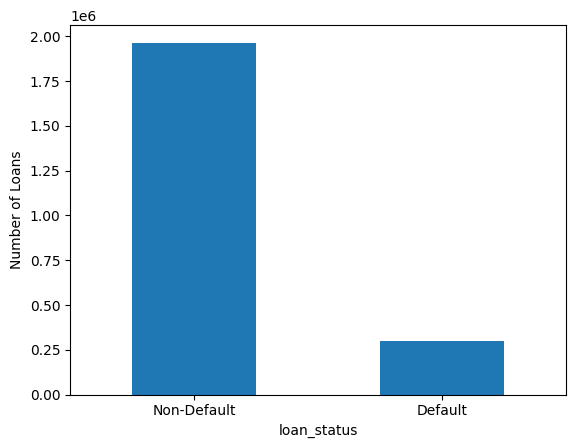

In [27]:
ax = processed_df.loan_status.value_counts().plot(kind='bar')
labels = ['Non-Default', 'Default']
ax.set_xticklabels(labels, rotation='horizontal')
ax.set_ylabel('Number of Loans')

# **Exploratory Data Analysis**

**`Defaults by Grade`**


Loans rated as "C" show the highest instances of defaults

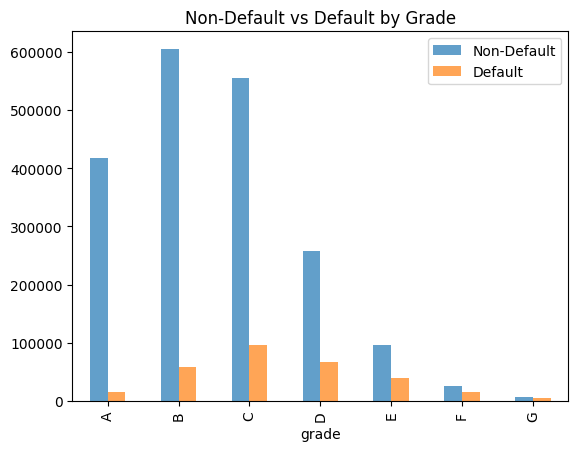

In [28]:
grade_default = pd.crosstab(processed_df['grade'], processed_df['loan_status'])

fig, ax = plt.subplots()

grade_default.plot.bar(legend=True, alpha=0.7, ax=ax)
plt.title("Non-Default vs Default by Grade")
ax.legend(["Non-Default", "Default"])

**Correlation in Credit Features**

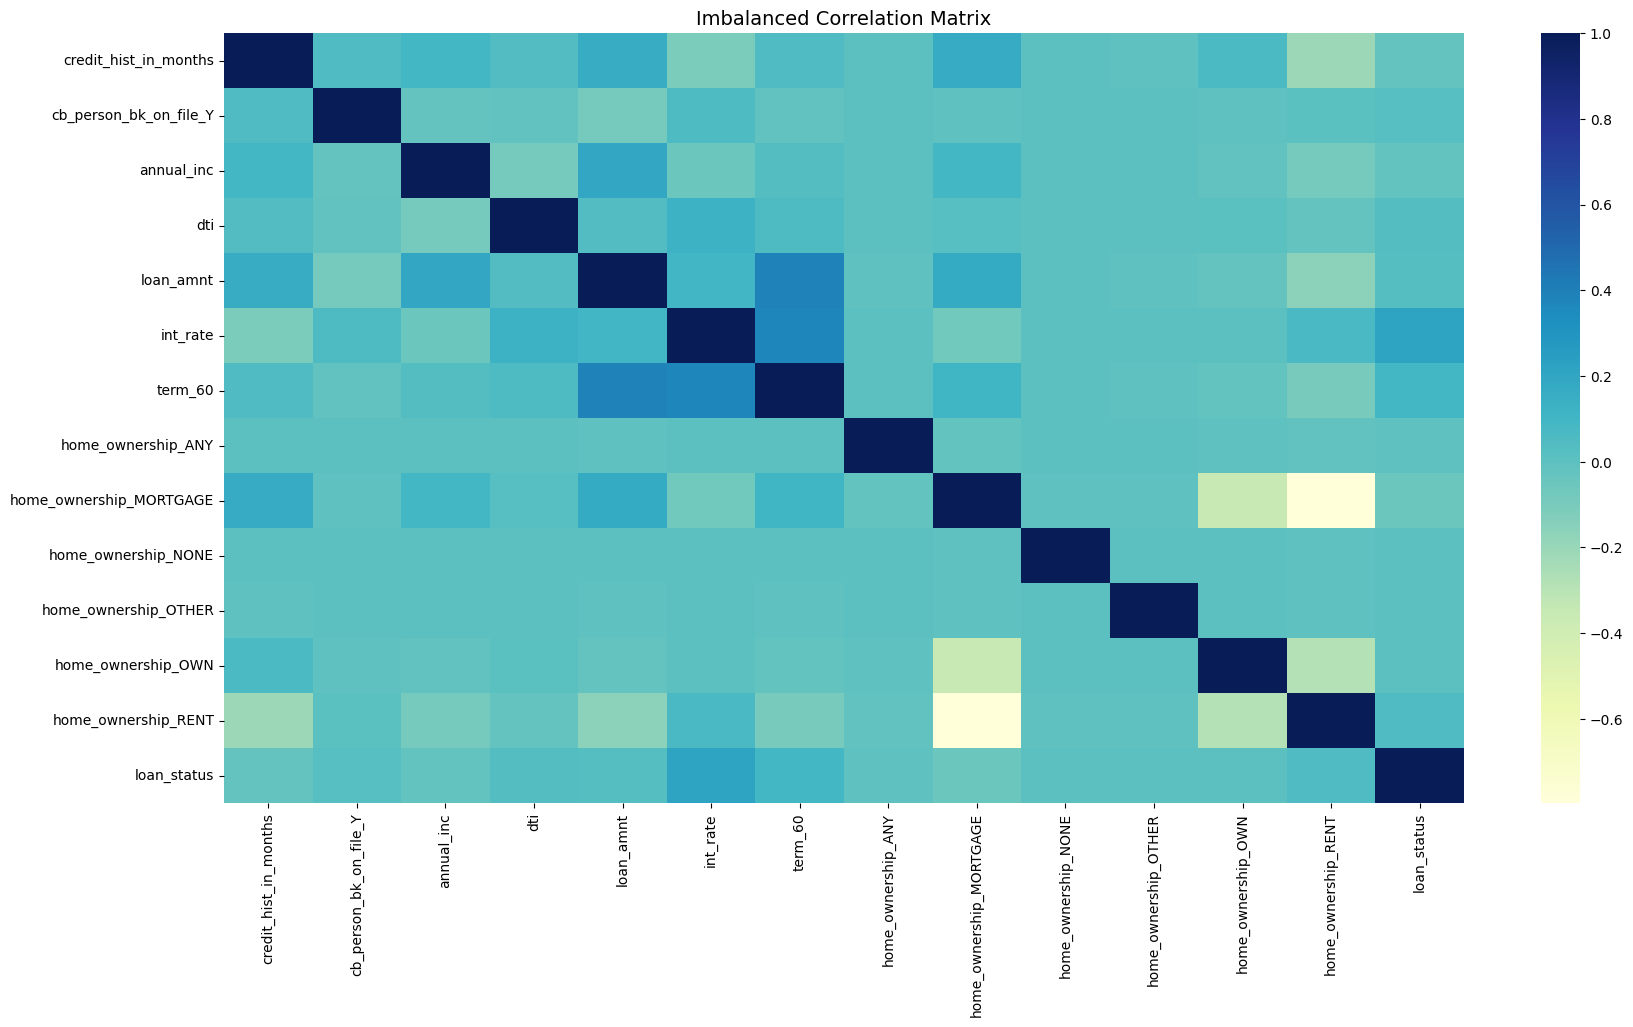

In [30]:
numeric_df = processed_df.select_dtypes(include=[np.number])

# Sample figsize in inches
fig, ax = plt.subplots(figsize=(20,10))

# Imbalanced DataFrame Correlation
corr = numeric_df.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)
plt.show()

 **Undersampling**

 The process where you randomly delete some of the observations from the majority class in order to match the numbers with the minority class

In [31]:
# Shuffle the Dataset.
random_data = processed_df.sample(frac=1,random_state=4)

# Put all the fraud class in a separate dataset.
default_df = random_data.loc[random_data['loan_status'] == 1]

#Randomly select 297033 observations from the non-fraud (majority class)
non_default_df = random_data.loc[random_data['loan_status'] == 0].sample(n=297033, random_state=42)

<ipython-input-35-db272f83d2ec>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='loan_status', data=US_df, palette='coolwarm')


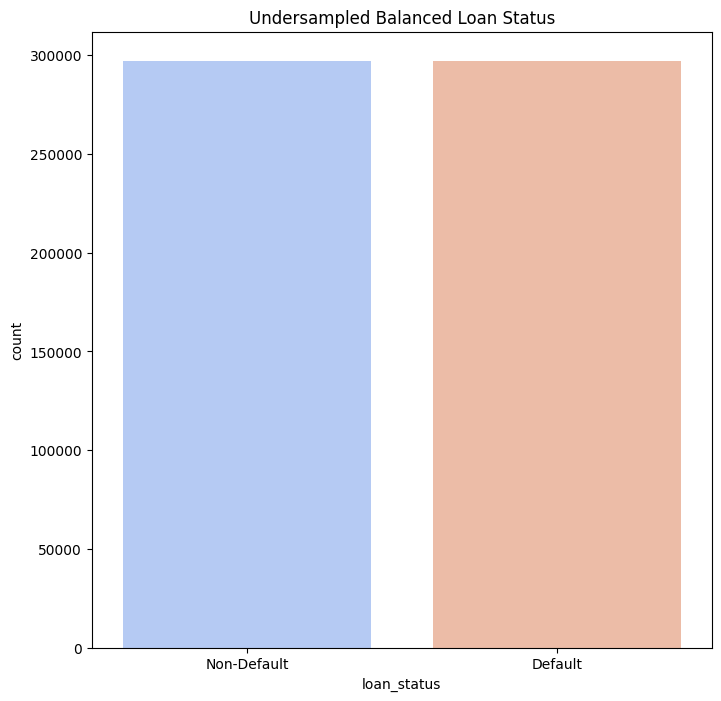

In [35]:
# Concatenate both dataframes again
US_df = pd.concat([default_df, non_default_df])

#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot(x='loan_status', data=US_df, palette='coolwarm')
plt.title('Undersampled Balanced Loan Status')
plt.xticks(ticks=(0,1), labels=('Non-Default', 'Default'))
plt.show()


In [36]:
# Create X and y using undersampled dataframe
X = US_df.drop(['loan_status', 'grade'], axis=1)
y = US_df['loan_status']

X_train_US, X_test_US, y_train_US, y_test_US = train_test_split(X, y, test_size=.4, random_state=123)

# **Logistic Regression**

In [37]:
# Create, train, and fit a logistic regression model
from sklearn.linear_model import LogisticRegression
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train_US, np.ravel(y_train_US))

# Create predictions of probability for loan status using test data
# .predict_proba creates an array of probabilities of default: [[non-defualt, default]]
lr_preds = clf_logistic.predict_proba(X_test_US)

# # Create dataframes of predictions and true labels
lr_preds_df = pd.DataFrame(lr_preds[:,1][0:], columns = ['lr_pred_PD'])
true_df = y_test_US

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), lr_preds_df], axis = 1))

        loan_status  lr_pred_PD
0                 0    0.530863
1                 0    0.510012
2                 0    0.419460
3                 0    0.631322
4                 1    0.639890
...             ...         ...
237622            1    0.742837
237623            1    0.570865
237624            1    0.327554
237625            0    0.528392
237626            0    0.752667

[237627 rows x 2 columns]


In [38]:
# Reassign loan status based on the threshold and print the predictions
lr_preds_df['lr_pred_loan_status_60'] = lr_preds_df['lr_pred_PD'].apply(lambda x: 1 if x > 0.60 else 0)
print("Non-Default / Default predictions at 60% Threshhold: ")
print(lr_preds_df['lr_pred_loan_status_60'].value_counts())

# Print the confusion matrix
from sklearn.metrics import confusion_matrix
print("Confusion Matrix at 60% Threshhold: ")
print(confusion_matrix(y_test_US, lr_preds_df['lr_pred_loan_status_60']))

# Print the classification report
from sklearn.metrics import classification_report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test_US, lr_preds_df['lr_pred_loan_status_60'], target_names=target_names))

Non-Default / Default predictions at 60% Threshhold: 
lr_pred_loan_status_60
0    176627
1     61000
Name: count, dtype: int64
Confusion Matrix at 60% Threshhold: 
[[98570 20451]
 [78057 40549]]
              precision    recall  f1-score   support

 Non-Default       0.56      0.83      0.67    119021
     Default       0.66      0.34      0.45    118606

    accuracy                           0.59    237627
   macro avg       0.61      0.59      0.56    237627
weighted avg       0.61      0.59      0.56    237627



In [39]:
# Reassign loan status based on the threshold and print the predictions
lr_preds_df['lr_pred_loan_status_50'] = lr_preds_df['lr_pred_PD'].apply(lambda x: 1 if x > 0.50 else 0)
print("Non-Default / Default t predictions at 50% Threshhold: ")
print(lr_preds_df['lr_pred_loan_status_50'].value_counts())

# Print the confusion matrix
from sklearn.metrics import confusion_matrix
print("Confusion Matrix at 50% Threshhold: ")
print(confusion_matrix(y_test_US, lr_preds_df['lr_pred_loan_status_50']))

# Print the classification report
from sklearn.metrics import classification_report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test_US, lr_preds_df['lr_pred_loan_status_50'], target_names=target_names))

Non-Default / Default t predictions at 50% Threshhold: 
lr_pred_loan_status_50
1    138918
0     98709
Name: count, dtype: int64
Confusion Matrix at 50% Threshhold: 
[[62229 56792]
 [36480 82126]]
              precision    recall  f1-score   support

 Non-Default       0.63      0.52      0.57    119021
     Default       0.59      0.69      0.64    118606

    accuracy                           0.61    237627
   macro avg       0.61      0.61      0.60    237627
weighted avg       0.61      0.61      0.60    237627



# **Plotting AUC for Logistic Regression Classification with Undersampled Data**

0.6074856813409251


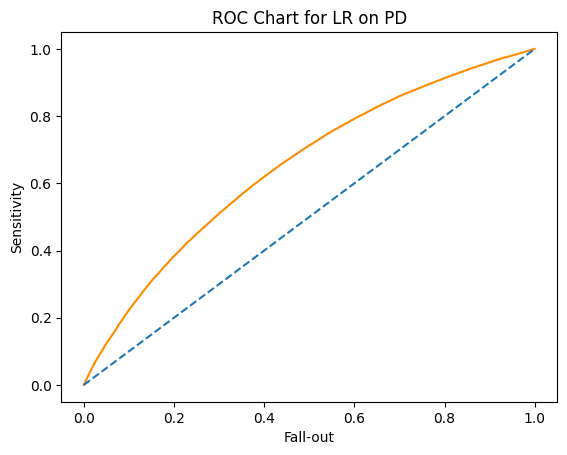

In [40]:
# Print the accuracy score the model
print(clf_logistic.score(X_test_US, y_test_US))

# Plot the ROC curve of the probabilities of default
from sklearn.metrics import roc_curve

lr_prob_default = lr_preds[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test_US, lr_prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Chart for LR on PD")
plt.xlabel("Fall-out")
plt.ylabel("Sensitivity")
plt.show()

# Compute the AUC and store it in a variable
from sklearn.metrics import roc_auc_score

lr_auc = roc_auc_score(y_test_US, lr_prob_default)

**Oversampling**

The process of generating synthetic data that tries to randomly generate a sample of the attributes from observations in the minority class. There are a number of methods used to oversample a dataset for a typical classification problem. The most common technique is called SMOTE (Synthetic Minority Over-sampling Technique)

In [43]:
# Create X and y using processed_df

X = processed_df.drop(['loan_status', 'grade'], axis=1)
y = processed_df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=123)

In [45]:


# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE(sampling_strategy='minority', random_state=7)

# Fit the model to generate the data.
oversampled_trainX, oversampled_trainY = sm.fit_resample(X_train, y_train)
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)
oversampled_train.columns = processed_df.drop(['grade'], axis=1).columns

# **Correlation in Credit Features AFTER oversampling**

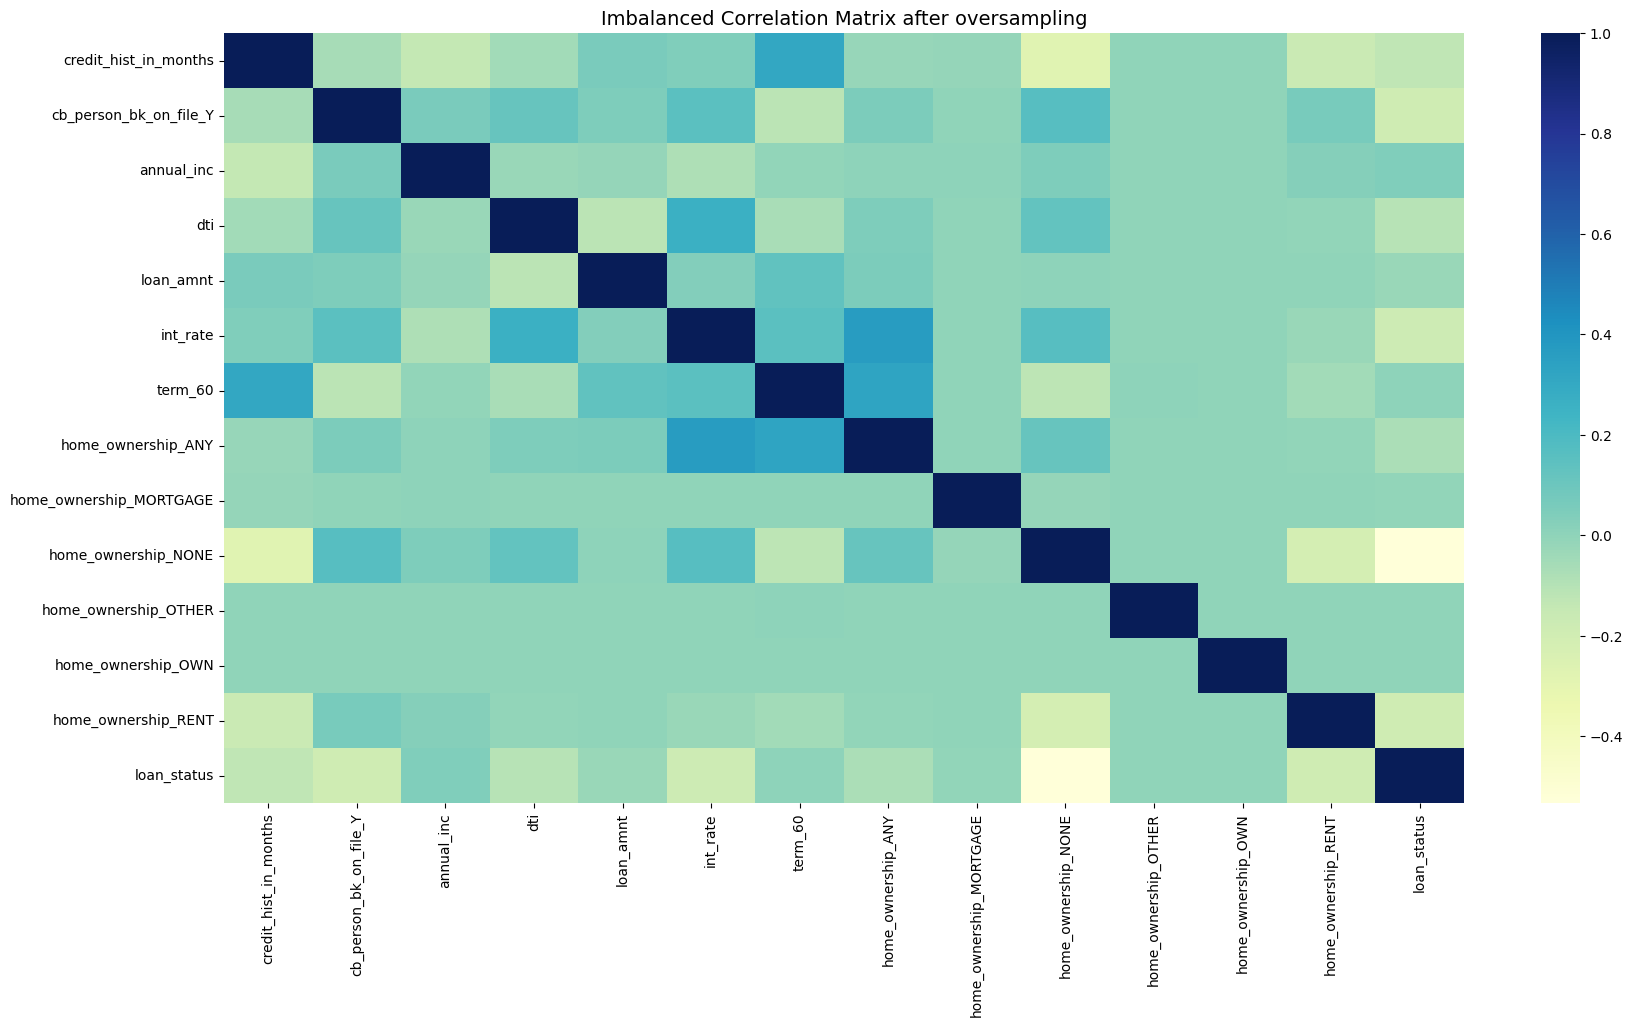

In [50]:
# Sample figsize in inches
fig, ax = plt.subplots(figsize=(20,10))

# Imbalanced DataFrame Correlation
corr = oversampled_train.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix after oversampling", fontsize=14)
plt.show()

# **Creating, Training, and Fitting a Logistic Regression Classfier Model to Oversampled Data**

In [51]:
# Create, train, and fit a logistic regression model
from sklearn.linear_model import LogisticRegression
clf_logistic = LogisticRegression(solver='lbfgs').fit(oversampled_trainX, np.ravel(oversampled_trainY))

# Create predictions of probability for loan status using test data
# .predict_proba creates an array of probabilities of default: [[non-defualt, default]]
lr_preds = clf_logistic.predict_proba(X_test)

# # Create dataframes of predictions and true labels
lr_preds_df = pd.DataFrame(lr_preds[:,1][0:], columns = ['lr_pred_PD'])
true_df = y_test

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), lr_preds_df], axis = 1))

        loan_status  lr_pred_PD
0                 0    0.566452
1                 0    0.349691
2                 0    0.526883
3                 0    0.451928
4                 0    0.395388
...             ...         ...
678196            1    0.534742
678197            0    0.394563
678198            1    0.497457
678199            0    0.656957
678200            1    0.515735

[678201 rows x 2 columns]


In [52]:
# Reassign loan status based on the threshold and print the predictions
lr_preds_df['lr_pred_loan_status_60'] = lr_preds_df['lr_pred_PD'].apply(lambda x: 1 if x > 0.60 else 0)
print("Non-Default / Default predictions at 60% Threshhold: ")
print(lr_preds_df['lr_pred_loan_status_60'].value_counts())

# Print the confusion matrix
from sklearn.metrics import confusion_matrix
print("Confusion Matrix at 60% Threshhold: ")
print(confusion_matrix(y_test, lr_preds_df['lr_pred_loan_status_60']))

# Print the classification report
from sklearn.metrics import classification_report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, lr_preds_df['lr_pred_loan_status_60'], target_names=target_names))

Non-Default / Default predictions at 60% Threshhold: 
lr_pred_loan_status_60
0    535653
1    142548
Name: count, dtype: int64
Confusion Matrix at 60% Threshhold: 
[[478596 110154]
 [ 57057  32394]]
              precision    recall  f1-score   support

 Non-Default       0.89      0.81      0.85    588750
     Default       0.23      0.36      0.28     89451

    accuracy                           0.75    678201
   macro avg       0.56      0.59      0.57    678201
weighted avg       0.81      0.75      0.78    678201



In [53]:
# Reassign loan status based on the threshold and print the predictions
lr_preds_df['lr_pred_loan_status_50'] = lr_preds_df['lr_pred_PD'].apply(lambda x: 1 if x > 0.50 else 0)
print("Non-Default / Default t predictions at 50% Threshhold: ")
print(lr_preds_df['lr_pred_loan_status_50'].value_counts())

# Print the confusion matrix
from sklearn.metrics import confusion_matrix
print("Confusion Matrix at 50% Threshhold: ")
print(confusion_matrix(y_test, lr_preds_df['lr_pred_loan_status_50']))

# Print the classification report
from sklearn.metrics import classification_report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, lr_preds_df['lr_pred_loan_status_50'], target_names=target_names))

Non-Default / Default t predictions at 50% Threshhold: 
lr_pred_loan_status_50
0    344907
1    333294
Name: count, dtype: int64
Confusion Matrix at 50% Threshhold: 
[[316240 272510]
 [ 28667  60784]]
              precision    recall  f1-score   support

 Non-Default       0.92      0.54      0.68    588750
     Default       0.18      0.68      0.29     89451

    accuracy                           0.56    678201
   macro avg       0.55      0.61      0.48    678201
weighted avg       0.82      0.56      0.63    678201



# **Plotting AUC for Logistic Regression Classification with Oversampled Data**

0.5559177883842695


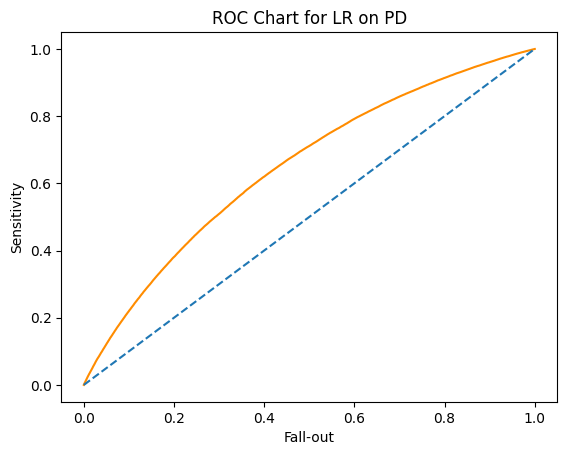

In [54]:
# Print the accuracy score the model
print(clf_logistic.score(X_test, y_test))

# Plot the ROC curve of the probabilities of default
from sklearn.metrics import roc_curve

lr_prob_default = lr_preds[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test, lr_prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Chart for LR on PD")
plt.xlabel("Fall-out")
plt.ylabel("Sensitivity")
plt.show()

# Compute the AUC and store it in a variable
from sklearn.metrics import roc_auc_score

lr_auc = roc_auc_score(y_test, lr_prob_default)

# **Creating, Training, and Fitting a Balanced Bagging Classfier Model to Oversampled Data**

In [55]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Create an object of the classifier and fit oversampled training data to the object
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0).fit(oversampled_trainX, np.ravel(oversampled_trainY))

# Create predictions of probability for loan status using test data
bbc_preds = bbc.predict_proba(X_test)

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_bagging.py:353: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


In [56]:
# Create dataframes of predictions and true labels
bbc_preds_df = pd.DataFrame(bbc_preds[:,1][0:], columns = ['bbc_pred_PD'])
true_df = y_test

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), bbc_preds_df], axis = 1))

        loan_status  bbc_pred_PD
0                 0          0.1
1                 0          0.0
2                 0          0.0
3                 0          0.3
4                 0          0.0
...             ...          ...
678196            1          0.2
678197            0          0.0
678198            1          0.1
678199            0          0.3
678200            1          0.1

[678201 rows x 2 columns]


In [57]:
# Reassign loan status based on the threshold and print the predictions
bbc_preds_df['bbc_pred_loan_status_60'] = bbc_preds_df['bbc_pred_PD'].apply(lambda x: 1 if x > 0.60 else 0)
print("Non-Default / Default predictions at 60% Threshhold: ")
print(bbc_preds_df['bbc_pred_loan_status_60'].value_counts())

# Print the confusion matrix
from sklearn.metrics import confusion_matrix
print("Confusion Matrix at 60% Threshhold: ")
print(confusion_matrix(y_test, bbc_preds_df['bbc_pred_loan_status_60']))

# Print the classification report
from sklearn.metrics import classification_report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, bbc_preds_df['bbc_pred_loan_status_60'], target_names=target_names))

Non-Default / Default predictions at 60% Threshhold: 
bbc_pred_loan_status_60
0    662855
1     15346
Name: count, dtype: int64
Confusion Matrix at 60% Threshhold: 
[[577846  10904]
 [ 85009   4442]]
              precision    recall  f1-score   support

 Non-Default       0.87      0.98      0.92    588750
     Default       0.29      0.05      0.08     89451

    accuracy                           0.86    678201
   macro avg       0.58      0.52      0.50    678201
weighted avg       0.79      0.86      0.81    678201



In [58]:
# Reassign loan status based on the threshold and print the predictions
bbc_preds_df['bbc_pred_loan_status_50'] = bbc_preds_df['bbc_pred_PD'].apply(lambda x: 1 if x > 0.50 else 0)
print("Non-Default / Default predictions at 50% Threshhold: ")
print(bbc_preds_df['bbc_pred_loan_status_50'].value_counts())

# Print the confusion matrix
from sklearn.metrics import confusion_matrix
print("Confusion Matrix at 50% Threshhold: ")
print(confusion_matrix(y_test, bbc_preds_df['bbc_pred_loan_status_50']))

# Print the classification report
from sklearn.metrics import classification_report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, bbc_preds_df['bbc_pred_loan_status_50'], target_names=target_names))

Non-Default / Default predictions at 50% Threshhold: 
bbc_pred_loan_status_50
0    646721
1     31480
Name: count, dtype: int64
Confusion Matrix at 50% Threshhold: 
[[565862  22888]
 [ 80859   8592]]
              precision    recall  f1-score   support

 Non-Default       0.87      0.96      0.92    588750
     Default       0.27      0.10      0.14     89451

    accuracy                           0.85    678201
   macro avg       0.57      0.53      0.53    678201
weighted avg       0.80      0.85      0.81    678201



0.8470261766054606


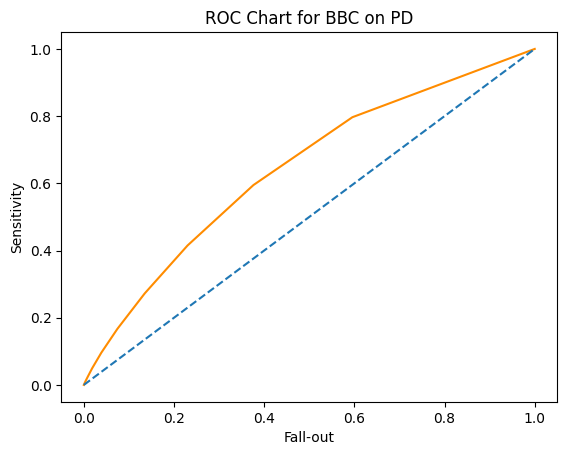

In [59]:
# Print the accuracy score the model
print(bbc.score(X_test, y_test))

# Plot the ROC curve of the probabilities of default
from sklearn.metrics import roc_curve

bbc_prob_default = bbc_preds[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test, bbc_prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Chart for BBC on PD")
plt.xlabel("Fall-out")
plt.ylabel("Sensitivity")
plt.show()

# Compute the AUC and store it in a variable
from sklearn.metrics import roc_auc_score

bbc_auc = roc_auc_score(y_test, bbc_prob_default)

# **Creating, Training, and Fitting a GBT Model to Oversampled Data**

In [60]:
# Train a model
import xgboost as xgb
clf_gbt = xgb.XGBClassifier().fit(oversampled_trainX, np.ravel(oversampled_trainY))

# Predict with a model
# .predict_proba creates an array of probabilities of default: [[non-default, default]]
gbt_preds = clf_gbt.predict_proba(X_test)

# Create dataframes of first five predictions, and first five true labels
gbt_preds_df = pd.DataFrame(gbt_preds[:,1][0:], columns = ['gbt_pred_PD'])
true_df = y_test

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), gbt_preds_df], axis = 1))

        loan_status  gbt_pred_PD
0                 0     0.206833
1                 0     0.020225
2                 0     0.145272
3                 0     0.213797
4                 0     0.031579
...             ...          ...
678196            1     0.328635
678197            0     0.273603
678198            1     0.190576
678199            0     0.532132
678200            1     0.407616

[678201 rows x 2 columns]


In [61]:
# Reassign loan status based on the threshold and print the predictions
gbt_preds_df['gbt_pred_loan_status_60'] = gbt_preds_df['gbt_pred_PD'].apply(lambda x: 1 if x > 0.60 else 0)
print("Non-Default / Default  predictions at 60% Threshhold: ")
print(gbt_preds_df['gbt_pred_loan_status_60'].value_counts())

# Print the confusion matrix
print("Confusion Matrix at 60% Threshhold: ")
print(confusion_matrix(y_test, gbt_preds_df['gbt_pred_loan_status_60']))

# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds_df['gbt_pred_loan_status_60'], target_names=target_names))

Non-Default / Default  predictions at 60% Threshhold: 
gbt_pred_loan_status_60
0    635589
1     42612
Name: count, dtype: int64
Confusion Matrix at 60% Threshhold: 
[[556985  31765]
 [ 78604  10847]]
              precision    recall  f1-score   support

 Non-Default       0.88      0.95      0.91    588750
     Default       0.25      0.12      0.16     89451

    accuracy                           0.84    678201
   macro avg       0.57      0.53      0.54    678201
weighted avg       0.79      0.84      0.81    678201



In [62]:
# Reassign loan status based on the threshold and print the predictions
gbt_preds_df['gbt_pred_loan_status_50'] = gbt_preds_df['gbt_pred_PD'].apply(lambda x: 1 if x > 0.50 else 0)
print("Non-Default / Default predictions at 50% Threshhold: ")
print(gbt_preds_df['gbt_pred_loan_status_50'].value_counts())

# Print the confusion matrix
print("Confusion Matrix at 50% Threshhold: ")
print(confusion_matrix(y_test, gbt_preds_df['gbt_pred_loan_status_50']))

# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds_df['gbt_pred_loan_status_50'], target_names=target_names))

Non-Default / Default predictions at 50% Threshhold: 
gbt_pred_loan_status_50
0    596437
1     81764
Name: count, dtype: int64
Confusion Matrix at 50% Threshhold: 
[[526999  61751]
 [ 69438  20013]]
              precision    recall  f1-score   support

 Non-Default       0.88      0.90      0.89    588750
     Default       0.24      0.22      0.23     89451

    accuracy                           0.81    678201
   macro avg       0.56      0.56      0.56    678201
weighted avg       0.80      0.81      0.80    678201



0.8065632459993424


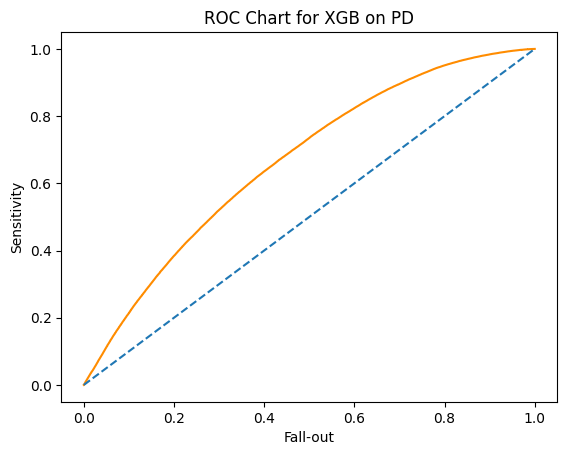

In [63]:
# Print the accuracy score the model
print(clf_gbt.score(X_test, y_test))

# Plot the ROC curve of the probabilities of default
from sklearn.metrics import roc_curve

xgb_prob_default = gbt_preds[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test, xgb_prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Chart for XGB on PD")
plt.xlabel("Fall-out")
plt.ylabel("Sensitivity")
plt.show()

# Compute the AUC and store it in a variable
from sklearn.metrics import roc_auc_score

xgb_auc = roc_auc_score(y_test, xgb_prob_default)

# **Modeling Five C's Portfolio Expected Loss using Balanced Bagging Classifier and XGB Classfier predicted probabilities of default**

In [64]:
# Creating a portfolio datafram
portfolio_5c = pd.DataFrame(gbt_preds[:,1][0:], columns = ['gbt_prob_default'])
portfolio_5c.index = X_test.index
portfolio_5c['bbc_prob_default'] = bbc_preds[:,1][0:]
portfolio_5c['lr_prob_default'] = lr_preds[:,1][0:]
portfolio_5c['lgd'] = 1 # Assumes that given a default, entire loan is a loss with no recoverable amounts
portfolio_5c['loan_amnt'] = X_test.loan_amnt
portfolio_5c.head()

,gbt_prob_default,bbc_prob_default,lr_prob_default,lgd,loan_amnt
739904,0.206833,0.1,0.566452,1,6000
798388,0.020225,0.0,0.349691,1,7000
96237,0.145272,0.0,0.526883,1,15000
1749328,0.213797,0.3,0.451928,1,24000
1849506,0.031579,0.0,0.395388,1,6500


In [65]:
# Create expected loss columns for each model using the formula
portfolio_5c['gbt_expected_loss'] = portfolio_5c['gbt_prob_default'] * portfolio_5c['lgd'] * portfolio_5c['loan_amnt']
portfolio_5c['bbc_expected_loss'] = portfolio_5c['bbc_prob_default'] * portfolio_5c['lgd'] * portfolio_5c['loan_amnt']
portfolio_5c['lr_expected_loss'] = portfolio_5c['lr_prob_default'] * portfolio_5c['lgd'] * portfolio_5c['loan_amnt']

# Print the total portfolio size
print('Portfolio size: $' + "{:,.2f}".format(np.sum(portfolio_5c['loan_amnt'])))

# Print the sum of the expected loss for bbc
print('BBC expected loss: $' + "{:,.2f}".format(np.sum(portfolio_5c['bbc_expected_loss'])))

# Print the sum of the expected loss for gbt
print('GBT expected loss: $' + "{:,.2f}".format(np.sum(portfolio_5c['gbt_expected_loss'])))

# Print the sum of the expected loss for lr
print('LR expected loss: $' + "{:,.2f}".format(np.sum(portfolio_5c['lr_expected_loss'])))

# Print portfolio first five rows
portfolio_5c.head()

Portfolio size: $10,208,879,175.00
BBC expected loss: $1,695,802,901.67
GBT expected loss: $2,743,159,342.49
LR expected loss: $4,938,979,286.49


,gbt_prob_default,bbc_prob_default,lr_prob_default,lgd,loan_amnt,gbt_expected_loss,bbc_expected_loss,lr_expected_loss
739904,0.206833,0.1,0.566452,1,6000,1241.000354,600.0,3398.713334
798388,0.020225,0.0,0.349691,1,7000,141.572990,0.0,2447.839275
96237,0.145272,0.0,0.526883,1,15000,2179.084048,0.0,7903.251907
1749328,0.213797,0.3,0.451928,1,24000,5131.132007,7200.0,10846.278381
1849506,0.031579,0.0,0.395388,1,6500,205.260346,0.0,2570.019752


# **TIME TO DEFAULT PREDICTION**

We can use the following features contained in the raw data to predict time to default:

`emp_length`, `chargeoff_within_12_mths`, `mths_since_last_delinq`, `mths_since_last_record`, `mths_since_last_major_derog`, `mths_since_recent_revol_delinq`

These feaure provide an indication of time in months since a negative credit event (i.e. an event that has a negative impact on a customers credit history such as late payment, bankruptcy, loan default, civil lawsuit, etc).

These features will be used with the processed_df features to model time to default using Kaplan Meier Estimates and Cox Proportional Hazard Models.

In [66]:
preprocess_TTD_df = raw_data[['emp_length', 'chargeoff_within_12_mths',
                              'mths_since_last_delinq', 'mths_since_last_record',
                              'mths_since_last_major_derog', 'mths_since_recent_revol_delinq']].copy()

In [67]:
preprocess_TTD_df.head()

,emp_length,chargeoff_within_12_mths,mths_since_last_delinq,mths_since_last_record,mths_since_last_major_derog,mths_since_recent_revol_delinq
0,10+ years,0.0,NaN,45.0,NaN,NaN
1,10+ years,0.0,71.0,75.0,NaN,NaN
2,6 years,0.0,NaN,NaN,NaN,NaN
3,10+ years,0.0,NaN,NaN,NaN,NaN
4,10+ years,0.0,NaN,NaN,NaN,NaN


In [68]:
preprocess_TTD_df.isnull().sum()

emp_length                         146907
chargeoff_within_12_mths              145
mths_since_last_delinq            1158502
mths_since_last_record            1901512
mths_since_last_major_derog       1679893
mths_since_recent_revol_delinq    1520309
dtype: int64

In [69]:
preprocess_TTD_df.emp_length.value_counts()

emp_length
10+ years    748005
2 years      203677
< 1 year     189988
3 years      180753
1 year       148403
5 years      139698
4 years      136605
6 years      102628
7 years       92695
8 years       91914
9 years       79395
Name: count, dtype: int64

In [70]:
# fill in missing values with the most frequently occuring employment length
preprocess_TTD_df['emp_length'].fillna(preprocess_TTD_df['emp_length'].value_counts().index[0], inplace=True)

# create a dataframe of employment length for customers in dataset
emp_length_df = pd.DataFrame(pd.get_dummies(preprocess_TTD_df.emp_length, prefix='emp_length'))
emp_length_df.head()

# concat the emp_length dataframe with preprocess_TTD_df, dropping original columns
preprocess_TTD_df = pd.concat([preprocess_TTD_df, emp_length_df], axis=1, sort=False)
preprocess_TTD_df.drop(['emp_length'], axis=1, inplace=True)
preprocess_TTD_df.head()

,chargeoff_within_12_mths,mths_since_last_delinq,mths_since_last_record,mths_since_last_major_derog,mths_since_recent_revol_delinq,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year
0,0.0,NaN,45.0,NaN,NaN,False,True,False,False,False,False,False,False,False,False,False
1,0.0,71.0,75.0,NaN,NaN,False,True,False,False,False,False,False,False,False,False,False
2,0.0,NaN,NaN,NaN,NaN,False,False,False,False,False,False,True,False,False,False,False
3,0.0,NaN,NaN,NaN,NaN,False,True,False,False,False,False,False,False,False,False,False
4,0.0,NaN,NaN,NaN,NaN,False,True,False,False,False,False,False,False,False,False,False


In [71]:
# fill in missing values with the most frequently occuring chargeoff
preprocess_TTD_df['chargeoff_within_12_mths'].fillna(preprocess_TTD_df['chargeoff_within_12_mths'].value_counts().index[0], inplace=True)

# **mths_since_last_delinq, mths_since_last_record, mths_since_last_major_derog, mths_since_recent_revol_delinq**

LC Data Dictionary defines

`mths_since_last_delinq`: The number of months since the borrower's last delinquency.
`mthsSinceLastRecord`: The number of months since the last public record.
`mths_since_last_major_derog`: Months since most recent 90-day or worse rating
`mths_since_recent_revol_delinq`: Months since most recent revolving delinquency

Important to note that current consumer credit practices allows for delinquencies to stay on a consumer credit report for 7 years, so while information maybe missing, it does not mean that a delinquency has not occured.

With no addtional data given on these features, we will assume that delinquencies, records, major derogatory remarks, and months since last revolving delinquencies have since fallen off the consumer credit reports and can no longer be factored into consideration.

Will fill the missing these features with 0 months

In [72]:
preprocess_TTD_df.mths_since_last_delinq
print(preprocess_TTD_df.mths_since_last_delinq.describe())

count    1.102166e+06
mean     3.454092e+01
std      2.190047e+01
min      0.000000e+00
25%      1.600000e+01
50%      3.100000e+01
75%      5.000000e+01
max      2.260000e+02
Name: mths_since_last_delinq, dtype: float64


In [73]:
preprocess_TTD_df.mths_since_last_record
print(preprocess_TTD_df.mths_since_last_record .describe())

count    359156.000000
mean         72.312842
std          26.464094
min           0.000000
25%          55.000000
50%          74.000000
75%          92.000000
max         129.000000
Name: mths_since_last_record, dtype: float64


In [74]:
preprocess_TTD_df.mths_since_last_major_derog
print(preprocess_TTD_df.mths_since_last_major_derog.describe())

count    580775.000000
mean         44.164220
std          21.533121
min           0.000000
25%          27.000000
50%          44.000000
75%          62.000000
max         226.000000
Name: mths_since_last_major_derog, dtype: float64


In [75]:
preprocess_TTD_df.mths_since_recent_revol_delinq
print(preprocess_TTD_df.mths_since_recent_revol_delinq.describe())

count    740359.000000
mean         35.782223
std          22.307239
min           0.000000
25%          17.000000
50%          33.000000
75%          51.000000
max         202.000000
Name: mths_since_recent_revol_delinq, dtype: float64


In [76]:
preprocess_TTD_df.fillna(0, inplace=True)

In [78]:
preprocess_TTD_df.head()

,chargeoff_within_12_mths,mths_since_last_delinq,mths_since_last_record,mths_since_last_major_derog,mths_since_recent_revol_delinq,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year
0,0.0,0.0,45.0,0.0,0.0,False,True,False,False,False,False,False,False,False,False,False
1,0.0,71.0,75.0,0.0,0.0,False,True,False,False,False,False,False,False,False,False,False
2,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,True,False,False,False,False
3,0.0,0.0,0.0,0.0,0.0,False,True,False,False,False,False,False,False,False,False,False
4,0.0,0.0,0.0,0.0,0.0,False,True,False,False,False,False,False,False,False,False,False


In [79]:
preprocess_TTD_df.isnull().sum()

chargeoff_within_12_mths          0
mths_since_last_delinq            0
mths_since_last_record            0
mths_since_last_major_derog       0
mths_since_recent_revol_delinq    0
emp_length_1 year                 0
emp_length_10+ years              0
emp_length_2 years                0
emp_length_3 years                0
emp_length_4 years                0
emp_length_5 years                0
emp_length_6 years                0
emp_length_7 years                0
emp_length_8 years                0
emp_length_9 years                0
emp_length_< 1 year               0
dtype: int64

In [81]:
process_TTD_df = preprocess_TTD_df.copy()
process_TTD_df.head()

,chargeoff_within_12_mths,mths_since_last_delinq,mths_since_last_record,mths_since_last_major_derog,mths_since_recent_revol_delinq,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year
0,0.0,0.0,45.0,0.0,0.0,False,True,False,False,False,False,False,False,False,False,False
1,0.0,71.0,75.0,0.0,0.0,False,True,False,False,False,False,False,False,False,False,False
2,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,True,False,False,False,False
3,0.0,0.0,0.0,0.0,0.0,False,True,False,False,False,False,False,False,False,False,False
4,0.0,0.0,0.0,0.0,0.0,False,True,False,False,False,False,False,False,False,False,False


In [82]:
# create a dataframe of employment length for customers in dataset
grade_df = pd.DataFrame(pd.get_dummies(processed_df.grade, prefix='grade'))
grade_df.head()

# concat the emp_length dataframe with preprocess_TTD_df, dropping original columns
processed_df = pd.concat([processed_df, grade_df], axis=1, sort=False)
processed_df.drop(['grade'], axis=1, inplace=True)
processed_df.head()

,credit_hist_in_months,cb_person_bk_on_file_Y,annual_inc,dti,loan_amnt,int_rate,term_60,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,...,home_ownership_OWN,home_ownership_RENT,loan_status,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,208,1,55000.0,18.24,2500,13.56,0,0,0,0,...,0,1,0,False,False,True,False,False,False,False
1,371,1,90000.0,26.52,30000,18.94,1,0,1,0,...,0,0,0,False,False,False,True,False,False,False
2,90,0,59280.0,10.51,5000,17.97,0,0,1,0,...,0,0,0,False,False,False,True,False,False,False
3,151,0,92000.0,16.74,4000,18.94,0,0,1,0,...,0,0,0,False,False,False,True,False,False,False
4,212,0,57250.0,26.35,30000,16.14,1,0,1,0,...,0,0,0,False,False,True,False,False,False,False


In [83]:
final_processed = processed_df.join(process_TTD_df)

In [84]:
final_processed.columns

Index(['credit_hist_in_months', 'cb_person_bk_on_file_Y', 'annual_inc', 'dti',
       'loan_amnt', 'int_rate', 'term_60', 'home_ownership_ANY',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'loan_status', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F', 'grade_G', 'chargeoff_within_12_mths',
       'mths_since_last_delinq', 'mths_since_last_record',
       'mths_since_last_major_derog', 'mths_since_recent_revol_delinq',
       'emp_length_1 year', 'emp_length_10+ years', 'emp_length_2 years',
       'emp_length_3 years', 'emp_length_4 years', 'emp_length_5 years',
       'emp_length_6 years', 'emp_length_7 years', 'emp_length_8 years',
       'emp_length_9 years', 'emp_length_< 1 year'],
      dtype='object')

# **Survival Analysis with KMF**

In [85]:
%%capture
!pip install lifelines


In [86]:
from lifelines import KaplanMeierFitter

In [87]:
raw_data.grade.value_counts()

grade
B    663557
C    650053
A    433027
D    324424
E    135639
F     41800
G     12168
Name: count, dtype: int64

# **Instantiate KMF object**

In [88]:
kmf1 = KaplanMeierFitter() ## instantiate the class to create an object

tenure = final_processed['credit_hist_in_months']
event = final_processed['loan_status']

# **Time to Default (or negative credit event) for Grade A rated customers**

<Axes: xlabel='timeline'>

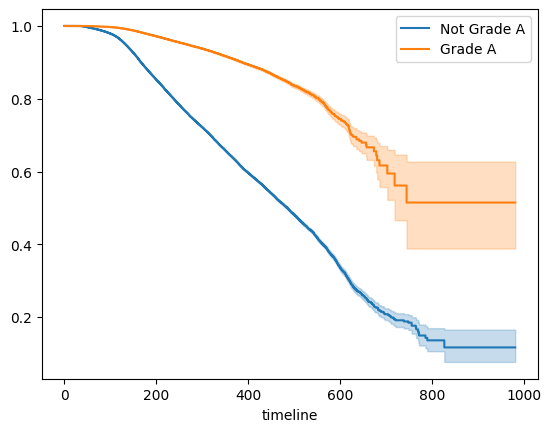

In [89]:
## Two Cohorts are compared. Cohort 1: Not Grade A Customers, and Cohort  2: Grade A CUstomers
grade_A = final_processed['grade_A']
not_grade_A = (grade_A == 0)      ## Cohort Not Grade A Customers, having the pandas series  for the 1st cohort
yes_grade_A = (grade_A == 1)     ## Cohort Grade A Customers, having the pandas series  for the 2nd cohort


## fit the model for 1st cohort
kmf1.fit(tenure[not_grade_A], event[not_grade_A], label='Not Grade A')
a1 = kmf1.plot()

## fit the model for 2nd cohort
kmf1.fit(tenure[yes_grade_A], event[yes_grade_A], label='Grade A')
kmf1.plot(ax=a1)
# a1.set_xlim(0, 100)

# **Time to Default (or negative credit event) for Grade B rated customers**

<Axes: xlabel='timeline'>

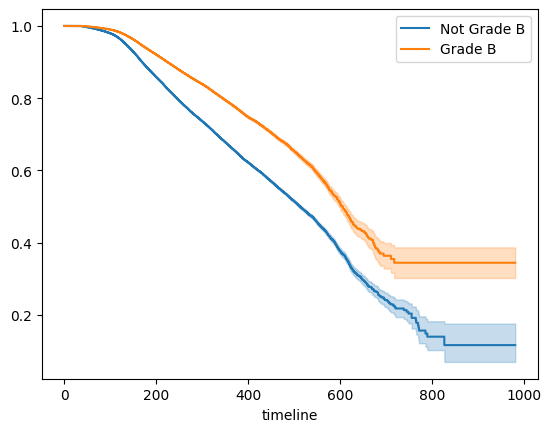

In [91]:
## Two Cohorts are compared. Cohort 1: Not Grade B Customers, and Cohort  2: Grade B CUstomers
grade_B = final_processed['grade_B']
not_grade_B = (grade_B == 0)      ## Cohort Not Grade B Customers, having the pandas series  for the 1st cohort
yes_grade_B = (grade_B == 1)     ## Cohort Grade B Customers, having the pandas series  for the 2nd cohort


## fit the model for 1st cohort
kmf1.fit(tenure[not_grade_B], event[not_grade_B], label='Not Grade B')
a1 = kmf1.plot()

## fit the model for 2nd cohort
kmf1.fit(tenure[yes_grade_B], event[yes_grade_B], label='Grade B')
kmf1.plot(ax=a1)

# **Time to Default (or negative credit event) for Grade C rated customers**

<Axes: xlabel='timeline'>

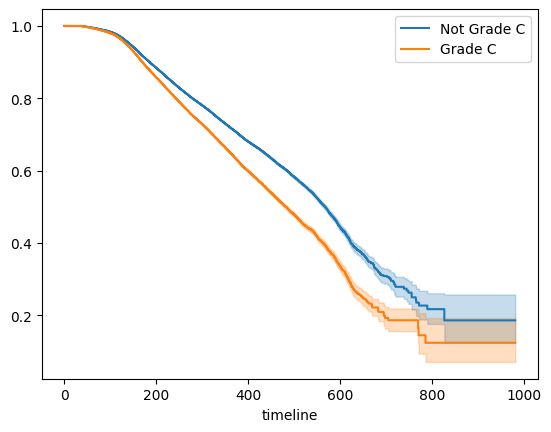

In [92]:
## Two Cohorts are compared. Cohort 1: Not Grade C Customers, and Cohort  2: Grade C CUstomers
grade_C = final_processed['grade_C']
not_grade_C = (grade_C == 0)      ## Cohort Not Grade C Customers, having the pandas series  for the 1st cohort
yes_grade_C = (grade_C == 1)     ## Cohort Grade C Customers, having the pandas series  for the 2nd cohort


## fit the model for 1st cohort
kmf1.fit(tenure[not_grade_C], event[not_grade_C], label='Not Grade C')
a1 = kmf1.plot()

## fit the model for 2nd cohort
kmf1.fit(tenure[yes_grade_C], event[yes_grade_C], label='Grade C')
kmf1.plot(ax=a1)

# **Time to Default (or negative credit event) for Grade D rated customers**

<Axes: xlabel='timeline'>

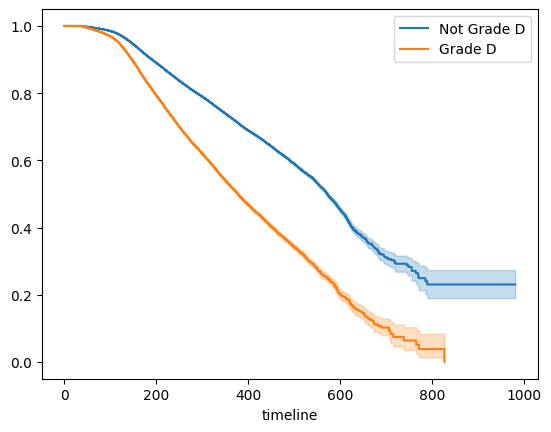

In [93]:
## Two Cohorts are compared. Cohort 1: Not Grade D Customers, and Cohort  2: Grade D CUstomers
grade_D = final_processed['grade_D']
not_grade_D = (grade_D == 0)      ## Cohort Not Grade D Customers, having the pandas series  for the 1st cohort
yes_grade_D = (grade_D == 1)     ## Cohort Grade D Customers, having the pandas series  for the 2nd cohort


## fit the model for 1st cohort
kmf1.fit(tenure[not_grade_D], event[not_grade_D], label='Not Grade D')
a1 = kmf1.plot()

## fit the model for 2nd cohort
kmf1.fit(tenure[yes_grade_D], event[yes_grade_D], label='Grade D')
kmf1.plot(ax=a1)



# **Time to Default (or negative credit event) for Grade F rated customers**

<Axes: xlabel='timeline'>

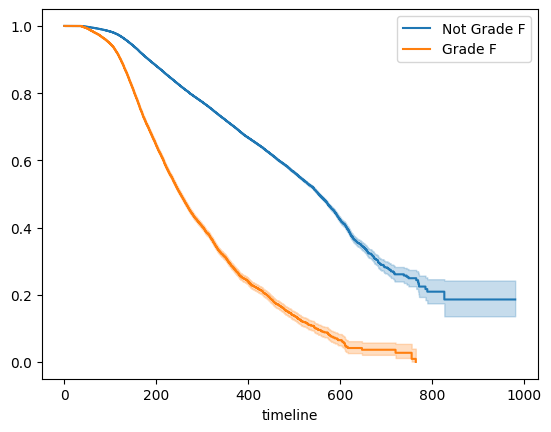

In [94]:
## Two Cohorts are compared. Cohort 1: Not Grade F Customers, and Cohort  2: Grade F CUstomers
grade_F = final_processed['grade_F']
not_grade_F = (grade_F == 0)      ## Cohort Not Grade F Customers, having the pandas series  for the 1st cohort
yes_grade_F = (grade_F == 1)     ## Cohort Grade F Customers, having the pandas series  for the 2nd cohort


## fit the model for 1st cohort
kmf1.fit(tenure[not_grade_F], event[not_grade_F], label='Not Grade F')
a1 = kmf1.plot()

## fit the model for 2nd cohort
kmf1.fit(tenure[yes_grade_F], event[yes_grade_F], label='Grade F')
kmf1.plot(ax=a1)

# **Time to Default (or negative credit event) for Grade G rated customers**

<Axes: xlabel='timeline'>

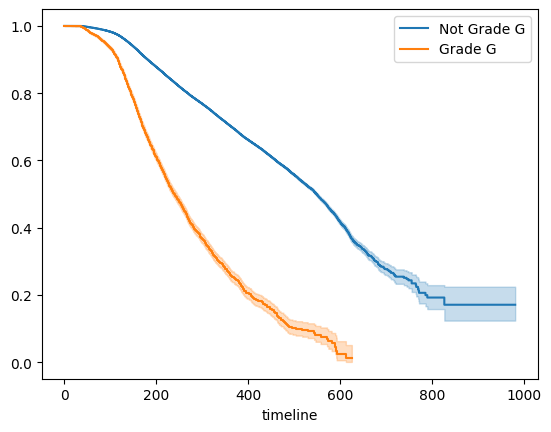

In [95]:
## Two Cohorts are compared. Cohort 1: Not Grade G Customers, and Cohort  2: Grade G CUstomers
grade_G = final_processed['grade_G']
not_grade_G = (grade_G == 0)      ## Cohort Not Grade G Customers, having the pandas series  for the 1st cohort
yes_grade_G = (grade_G == 1)     ## Cohort Grade G Customers, having the pandas series  for the 2nd cohort


## fit the model for 1st cohort
kmf1.fit(tenure[not_grade_G], event[not_grade_G], label='Not Grade G')
a1 = kmf1.plot()

## fit the model for 2nd cohort
kmf1.fit(tenure[yes_grade_G], event[yes_grade_G], label='Grade G')
kmf1.plot(ax=a1)

# **Intepreting the Plots**


The y-axis represent the probablilty that a default/credit negative event will occur at a specific point on the timeline (the x-axis).

As we move along the timeline, we can see the survival of loans not rated G (blue line) has a better survival probability then loans G. This is consistent with the fact that G-rated loans are the weakest in credit rating. Compare the G-rated loan plot to the loans rated A, the reverse is true. Loans rate A (higher financial and credit strength) have improved survival probability versus all other loans.